In [177]:
import graph_tool as gt
from graph_tool.spectral import adjacency
from graph_tool.topology import shortest_distance
import matplotlib.pylab as pl
from matplotlib.ticker import PercentFormatter
%matplotlib inline
import numpy as np
import numpy.random as npr
import scipy.sparse as sps
import tqdm

In [199]:
src = np.load('models/hotpot_models/src.npy')
dst = np.load('models/hotpot_models/dst.npy')
n_vertices = max(src.max(), dst.max()) + 1
g = gt.Graph(directed=True)
g.add_vertex(n_vertices)
g.add_edge_list(np.vstack([src, dst]).T)
a = adjacency(g)

In [200]:
a.sum(0).max(), a.sum(1).max()

(79.0, 189410.0)

In [237]:
in_deg = np.asarray(a.sum(1)).flatten()
out_deg = np.asarray(a.sum(0)).flatten()

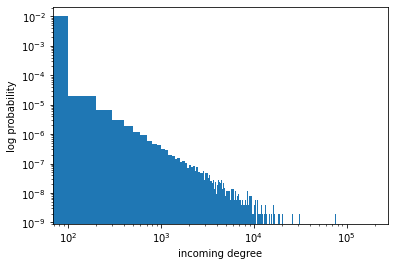

In [231]:
pl.xscale('log')
pl.yscale('log')
pl.xlabel('incoming degree')
pl.ylabel('log probability')
_ = pl.hist(in_deg, bins=int(in_deg.max()) // 100, density=True)

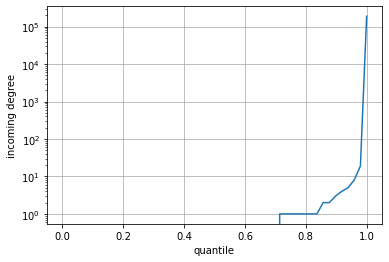

In [246]:
q = np.linspace(0, 1)
pl.grid()
pl.yscale('log')
pl.xlabel('quantile')
pl.ylabel('incoming degree')
pl.plot(q, np.quantile(in_deg, q))

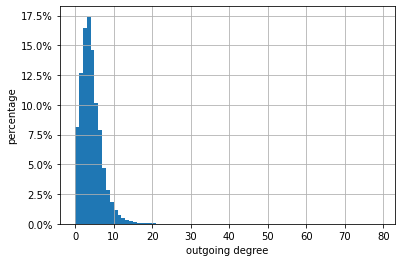

In [236]:
pl.grid()
pl.xlabel('outgoing degree')
pl.ylabel('percentage')
pl.gca().yaxis.set_major_formatter(PercentFormatter(1))
_ = pl.hist(out_deg, bins=int(out_deg.max()), density=True)

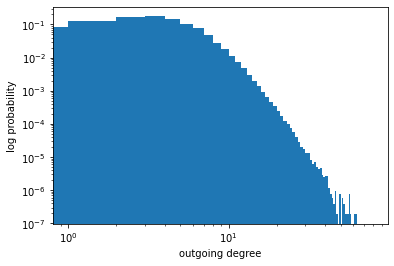

In [233]:
pl.xscale('log')
pl.yscale('log')
pl.xlabel('outgoing degree')
pl.ylabel('log probability')
_ = pl.hist(out_deg, bins=int(out_deg.max()), density=True)

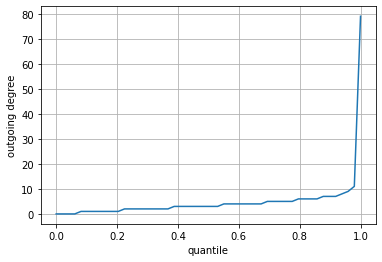

In [250]:
q = np.linspace(0, 1)
pl.grid()
pl.xlabel('quantile')
pl.ylabel('outgoing degree')
pl.plot(q, np.quantile(out_deg, q))

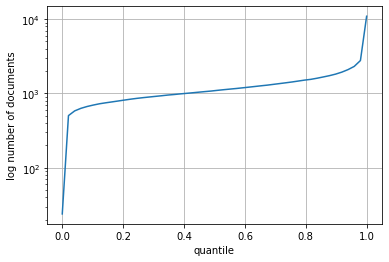

In [254]:
pl.grid()
pl.yscale('log')
pl.xlabel('quantile')
pl.ylabel('log number of documents')
n_results = np.load('n_results.npy')
q = np.linspace(0, 1)
pl.plot(q, np.quantile(n_results, q))

In [22]:
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool
from functools import partial

In [40]:
dists = [shortest_distance(g, u, v, directed=False, max_dist=10) for u, v in tqdm.tqdm(zip(gold0, gold1))]

7405it [05:41, 21.68it/s]


In [184]:
import importlib
tqdm = importlib.reload(tqdm)

In [185]:
dir_dists = [shortest_distance(g, u, v, directed=True, max_dist=10) for u, v in tqdm.tqdm(zip(gold0, gold1))]

7405it [05:28, 22.57it/s]


In [ ]:
with ThreadPool() as pool:
    dists = list(tqdm.tqdm(pool.starmap(partial(shortest_distance, g, directed=False, max_dist=10), zip(gold0, gold1))))

In [44]:
_dists = np.array(dists)

In [154]:
_dists.min(), _dists.max(), np.quantile(_dists, 0.99)

(1, 2147483647, 5.0)

In [188]:
max(dir_dists)

2147483647

In [190]:
np.sum(_dir_dists < max(dir_dists))

6172

(array([7.99189737e-01, 4.05131668e-04, 2.70087779e-04, 1.35043889e-03,
        1.35043889e-03, 3.24105334e-03, 6.48210668e-03, 6.07697502e-03,
        7.15732613e-03, 1.74476705e-01]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 10 Patch objects>)

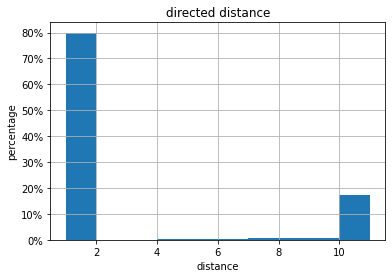

In [195]:
_dir_dists = np.array(dir_dists)
_dir_dists[_dir_dists == max(dir_dists)] = 11
pl.grid()
pl.title('directed distance')
pl.xlabel('distance')
pl.ylabel('percentage')
pl.gca().yaxis.set_major_formatter(PercentFormatter(1))
pl.hist(_dir_dists, bins=range(1, 12), align='mid', density=True)

(array([0.80138099, 0.05916599, 0.05957216, 0.06756025, 0.01232061]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

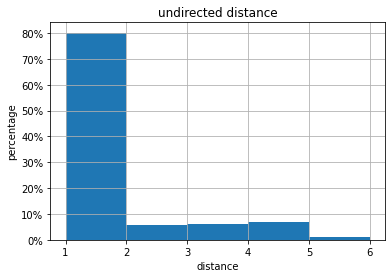

In [196]:
pl.grid()
pl.title('undirected distance')
pl.xlabel('distance')
pl.ylabel('percentage')
pl.gca().yaxis.set_major_formatter(PercentFormatter(1))
pl.hist(_dists, bins=range(1, 7), align='mid', density=True)

In [167]:
np.unique(_dists)

array([         1,          2,          3,          4,          5,
                6, 2147483647], dtype=int32)

In [84]:
nz, = np.nonzero(degree > np.quantile(degree, 0.995))

In [125]:
np.quantile(degree, 0.995)

82.0

In [150]:
a = adjacency(g).minimum(1)
d = np.asarray(a.sum(0)).squeeze().astype(np.int)
gt = d > np.quantile(d, 0.99)
a.data[gt.repeat(d)] = 0
a.eliminate_zeros()
a = a.transpose()
a.sum(0).max(), a.sum(1).max()

(45.0, 187315.0)

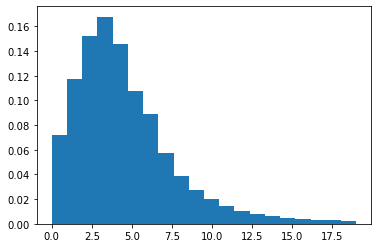

In [69]:
_ = pl.hist(degree[degree < 20], bins=20, density=True)

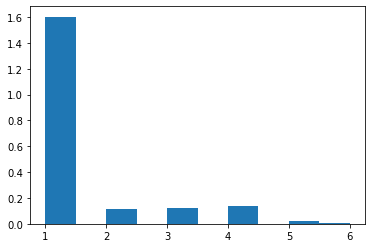

In [56]:
_ = pl.hist(_dists[_dists < 10], density=True)

In [115]:
gold0 = np.load('models/hotpot_models/gold0.npy')
gold1 = np.load('models/hotpot_models/gold1.npy')
data = np.ones(len(gold0))
indptr = np.arange(len(gold0) + 1)
_gold0 = sps.csr_matrix((data, gold0, indptr), shape=(len(gold0), n_vertices)).transpose()
_gold1 = sps.csr_matrix((data, gold1, indptr), shape=(len(gold1), n_vertices)).transpose()
gold = _gold0 + _gold1

In [20]:
k = 10
indices = np.load('models/hotpot_models/top%d_indices.npy' % k)
indptr = np.arange(0, len(indices) + 1, k)
data = np.ones_like(indices)
topk = sps.csr_matrix((data, indices, indptr), shape=(len(indices) // k, n_vertices)).transpose()

In [39]:
unique, counts = np.unique(np.asarray(topk.multiply(gold).sum(0)), return_counts=True)
unique, counts / len(gold0)

(array([0., 1., 2.]), array([0.156921  , 0.55881161, 0.28426739]))

In [174]:
visited = sps.csr_matrix(frontier.shape)
# frontier = _gold0; target = _gold1
# frontier = _gold1; target = _gold0
# frontier = gold; target = gold
# frontier = topk; target = _gold0
# frontier = topk; target = _gold1
frontier = visited = topk; target = gold
unique, counts = np.unique(np.asarray(target.multiply(visited).sum(0)), return_counts=True)
print(f'0-hop', np.quantile(visited.sum(0), 0.95), unique, counts / len(gold0))
for i in range(3):
    frontier = a @ frontier
    frontier.data = np.ones_like(frontier.data) * (npr.rand(len(frontier.data)) <= 1)
    frontier.eliminate_zeros()
    visited = frontier + visited
    visited = visited.minimum(1)
    unique, counts = np.unique(np.asarray(target.multiply(visited).sum(0)), return_counts=True)
    print(f'{i + 1}-hop', np.quantile(visited.sum(0), 0.95), unique, counts / len(gold0))

0-hop 10.0 [0. 1. 2.] [0.156921   0.55881161 0.28426739]
1-hop 122.0 [0. 1. 2.] [0.08845375 0.1249156  0.78663065]
2-hop 822.0 [0. 1. 2.] [0.07711006 0.11627279 0.80661715]
3-hop 4889.999999999989 [0. 1. 2.] [0.0686023  0.10992573 0.82147198]


1-hop 82.0 [0. 1.] [0.20823768 0.79176232]
2-hop 1367.0 [0. 1.] [0.2055368 0.7944632]
3-hop 10233.0 [0. 1.] [0.20108035 0.79891965]
4-hop 59494.0 [0. 1.] [0.18176907 0.81823093]
5-hop 278929.0 [0. 1.] [0.15381499 0.84618501]